# Data challenge 1: 
The objective of this data challenge is to explore the dataset located at: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data and build a classifier for predicting malignance.

## Contents
* Import and inspect data
* Data visualization
* First attempt at classification
* Hyper-parameter tuning

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

mpl.rcParams['figure.dpi']= 150

# Import and inspect data
Missing values in the data are indicated with "?", so I've imported the data as floats and assigned those values to NaN. It is interesting to note that all of the features and labels are ordinal.

In [2]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(data_url, 
                 names = ['thickness', 'sizeuniformity', 'shapeuniformity', 'adhesion', 'cellsize', 'barenuclei', 'chromatin', 'nucleoli', 'mitoses', 'class'],
                 dtype=float, 
                 na_values='?')
df.head()

,thickness,sizeuniformity,shapeuniformity,adhesion,cellsize,barenuclei,chromatin,nucleoli,mitoses,class
1000025.0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0
1002945.0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,2.0
1015425.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,2.0
1016277.0,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,2.0
1017023.0,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0


Data includes 9 features and one outcome variable (class 2 or 4). The objective is to predict the outcome variable from the predictors.

# Data visualization

## Look at the distributions of the data
Most appear to be skewed or bimodal. We can also see that the classes are not entirely even.

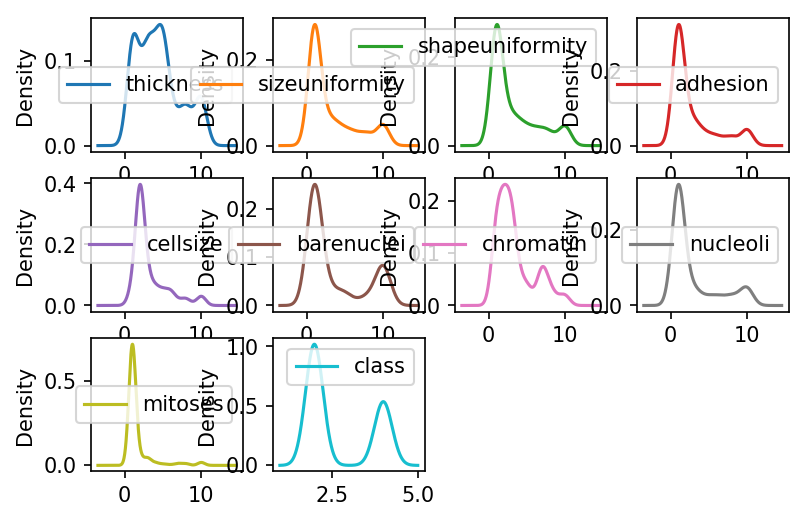

In [15]:
df.plot(kind='density', subplots=True, layout=(3,4), sharex = False)
plt.show()

## Look at absolute value of correlation coefficients
This is helpful for identifying redundant features, and for identifying features likely to be predictive for class. All features except mitoses seem to be highly correlated with class. Shape and size uniformity seem to be highly correlated, suggesting a need for dimensional reduction.

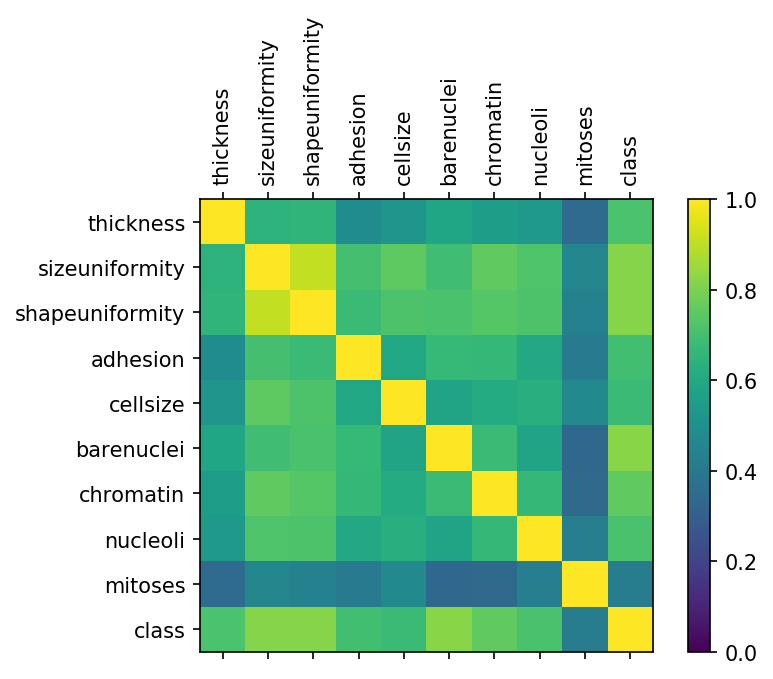

In [16]:
correlations = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(abs(correlations), vmin=0, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,10,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.xticks(rotation=90)
plt.show()

# First attempt at classification
## Use PCA for dimensional reduction
This will ensure highly-correlated features such as shape and size uniformity are not overweighted in the classification. The PCA plot shows that 1 component explains over 65% of the variance. The last principal component clearly doesn't convey much information. However, there isn't a great cutoff past that by the elbow method. 

Text(0,0.5,'total % variance explained')

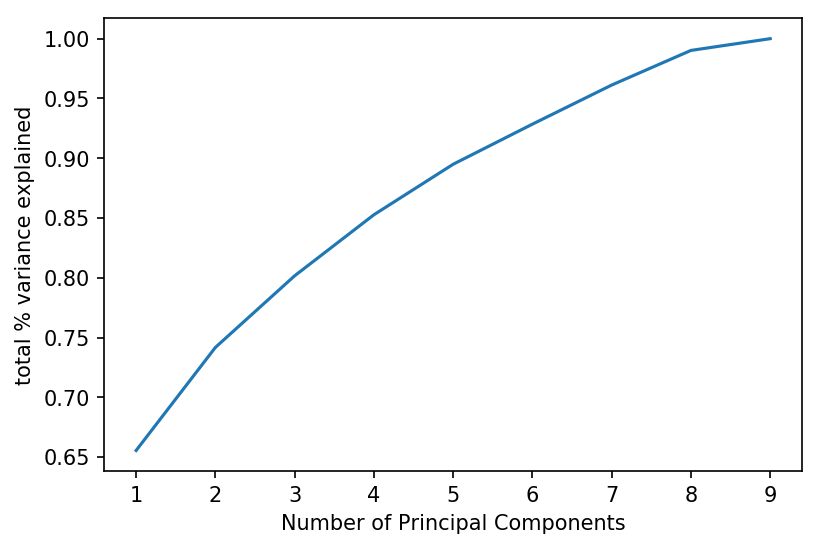

In [17]:
df_no_nan = df.dropna()

features = df.columns[:-1]
x = df_no_nan.loc[:, features].values
scaler = StandardScaler()
scaler.fit(X=x)
x_scaled = scaler.transform(x)
pca = PCA()
components = pca.fit_transform(x_scaled)
sns.lineplot(x=[i for i in range(1,len(pca.explained_variance_ratio_)+1)], 
             y=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('total % variance explained')

## Logistic regression classifier initialization
This is our first attempt at classification. Logistic regression assumes features are logical or continuous; however, we have ordinal features. This does not invalidate the method, but is something to keep under consideration. We will split off 33% of the data to test the classifier.

In [6]:
X = components
y = df_no_nan.loc[:, 'class'].values==4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


mdl_LR = LogisticRegression().fit(X_train, y_train)
pred_test = mdl_LR.predict(X_test)

## Evaluate classifier
### First we will look at the area under the ROC
The classifier performs well, with 97% AOC.

In [7]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, mdl_LR.predict_proba(X_test)[:,1])
aoc = metrics.auc(fpr, tpr)

print('AOC is: '+str(round(aoc,3)))

AOC is: 0.998


### Then we will look at the confusion matrix
There are an equal number of false positives as false negatives. False negatives are a larger problem than false positives for our application, so we will need to tune hyper-parameters to bias the classifier towards positives.

(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

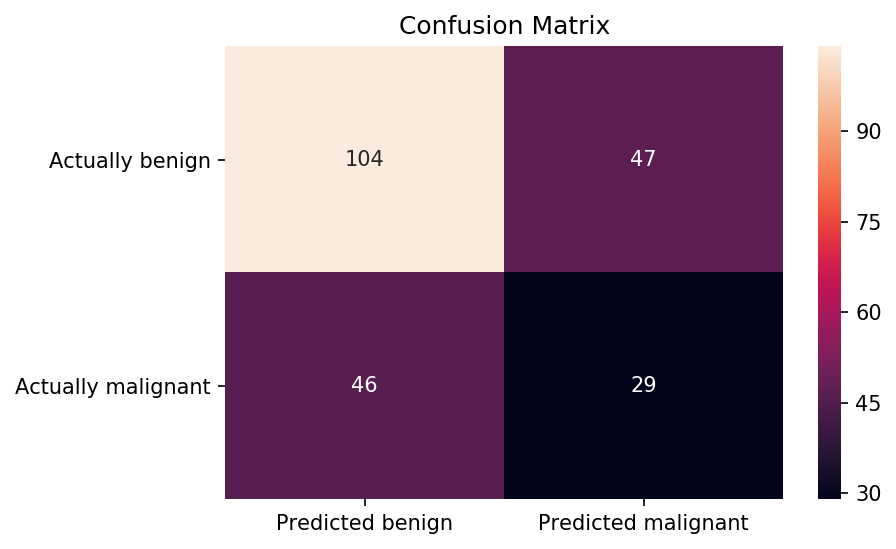

In [18]:
cfm = metrics.confusion_matrix(y_test, pred_test)
df_cfm = pd.DataFrame(cfm, index = ["Actually benign","Actually malignant"],
                  columns = ["Predicted benign","Predicted malignant"])
sns.heatmap(df_cfm, annot=True, fmt='d')
plt.title('Confusion Matrix')

plt.yticks(rotation=0)

### Finally we look at the actual ROC

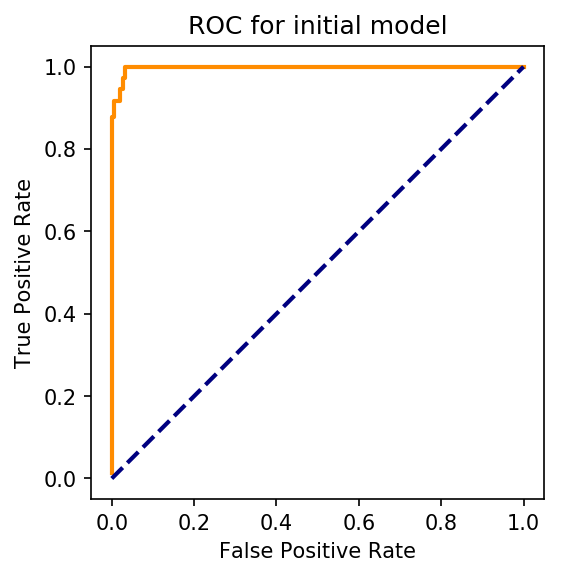

In [19]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for initial model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.axis('square')
plt.show()

# Hyperparameter tuning
Our initial model performs well, but we can improve it by tuning the class weights, which we initially assumed were equal, and the regularization hyperparameter C. We will now adjust our hyperparameters to improve the model and reduce our false negative rate.
## Initialize model
Model is initialized in the same way, and a test dataset is also withheld for final validation. This data will not be included in cross-validation

In [10]:
from sklearn.model_selection import GridSearchCV

X = components
y = df_no_nan.loc[:, 'class'].values==4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

density = 10

weight_list = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.99, 0.999]
C_list = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.33, 0.5, 1, 2, 4, 8, 16, 32, 100, 1000, 10000]
parameters = {'C': C_list, 
              'class_weight': [{True : x, False : 1-x} for x in weight_list]}
clf = GridSearchCV(LogisticRegression(), parameters)
clf = clf.fit(X_train, y_train)

The results are visualized as two heat maps. One for the training datasets and one for validation. Ideal hyper-parameters have the lowest validation error.

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0.5,32.0833,'class weights')

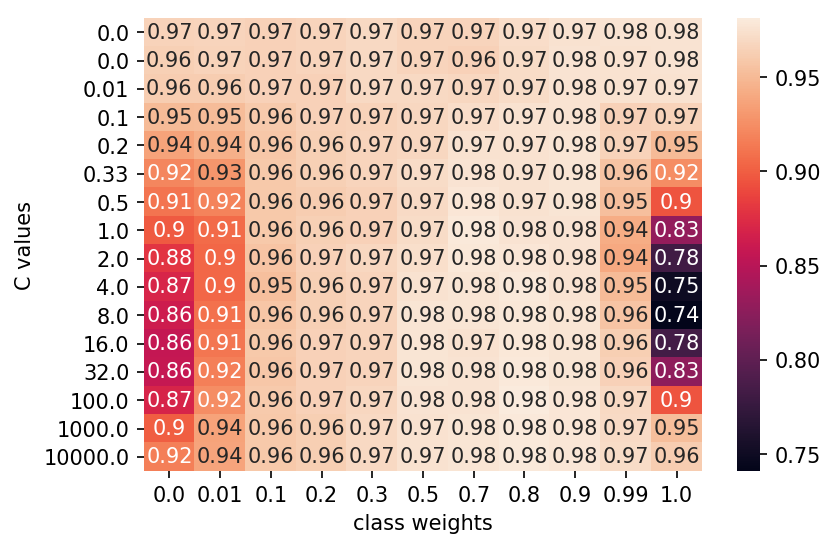

In [20]:
C_list_round = [round(i,2) for i in C_list]
weight_list_round = [round(i,2) for i in weight_list]

df_test_score = pd.DataFrame(np.reshape(clf.cv_results_.get("mean_train_score"),(len(C_list),len(weight_list))), 
                             index = C_list_round,
                  columns = weight_list_round)
sns.heatmap(df_test_score, annot=True)

plt.yticks(rotation=0)
plt.ylabel('C values')
plt.xlabel('class weights')

Text(0.5,32.0833,'class weights')

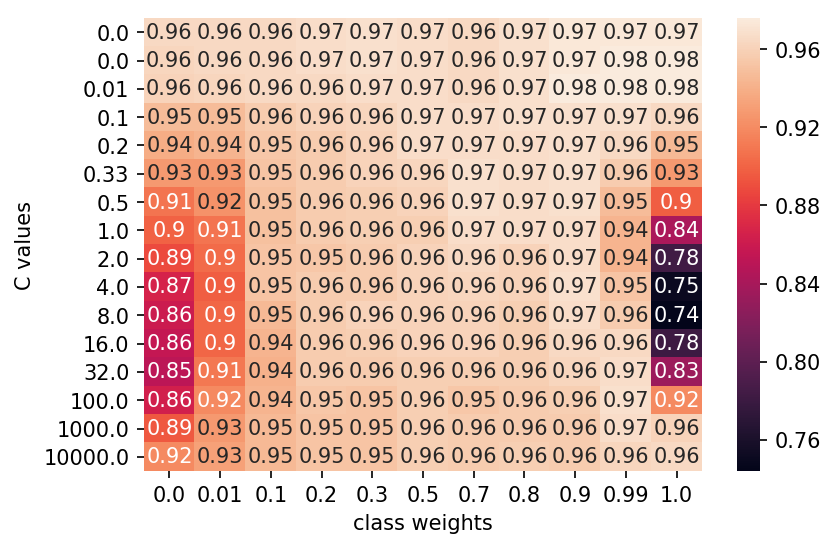

In [21]:
C_list_round = [round(i,2) for i in C_list]
weight_list_round = [round(i,2) for i in weight_list]

df_test_score = pd.DataFrame(np.reshape(clf.cv_results_.get("mean_test_score"),(len(C_list),len(weight_list))), 
                             index = C_list_round,
                  columns = weight_list_round)
sns.heatmap(df_test_score, annot=True)

plt.yticks(rotation=0)
plt.ylabel('C values')
plt.xlabel('class weights')

From the validation plot, it seems that variable class weights do not affect the performance of the classifier when the weights are between 0.1 and 0.9. This indicates underfitting. It makes sense to set that hyperparameter to 0.5. Performance does not seem to depend on C, so the default value of 1 can be used. This supports use of the base model. High values of C seem to have lower training error but test error is not affected, suggesting overfitting for values of C greater than 2.

# Conclusion
We have explored the dataset and built and tuned a logistic regression classifier. This classifier is effective with an area under the ROC of 0.97.